## Import Libraries

In [52]:
#
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


#
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#
import zipfile
from PIL import Image
import io
import os
import re
import cv2
from tqdm import tqdm
import random

# Tự động gắn nhãn (label) cho các hình ảnh dựa trên tên thư mục.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Unzip and Load Dataset

In [2]:
zip_train_path = 'train.zip'
zip_test_path = 'test1.zip'

In [3]:
# Extract zip file
def extract_zip(input_zip, output_dir):
    with zipfile.ZipFile(input_zip, 'r') as archive_zip:
        archive_zip.extractall(output_dir)
        print(f"Extracted images in {input_zip} to {output_dir}")

In [4]:
extract_zip('train.zip', 'train_data/')
extract_zip('test1.zip', 'test_data/')

Extracted images in train.zip to train_data/
Extracted images in test1.zip to test_data/


In [5]:
train_folder = 'train_data/train'
test_folder = 'test_data/test1'

In [6]:
# Get a list of img path
folders = [train_folder, test_folder]

for f in folders:
    # Lấy tên thư mục (bỏ số ở cuối nếu có)
    name = re.sub(r'\d+$', '', f.split('/')[-1])

    # Create a list of img path
    globals()[name + '_images_path'] = [os.path.join(f, img) for img in os.listdir(f) if img.endswith(('.jpg', '.png', '.jpeg'))]

### Data Exploration

In [7]:
# Count dataset size
print(f"Images in file train: {len(train_images_path)}")
print(f"Images in file test: {len(test_images_path)}")

Images in file train: 25000
Images in file test: 12500


In [8]:
# Data Visualization
def visualize(img_files_path, num_images=5):
    # Show sample images with their filenames
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(img_files_path[:num_images]):
        img = Image.open(img_path)

        # Display the image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

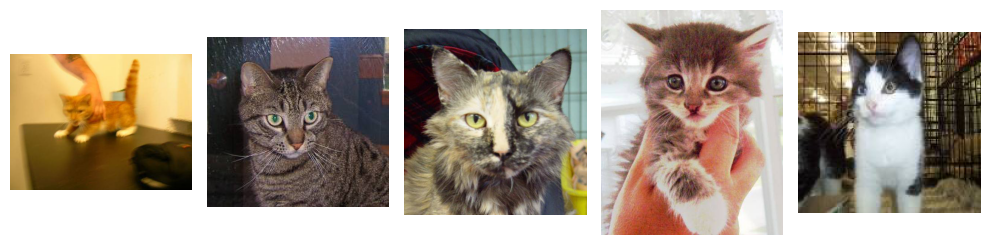

In [9]:
visualize(train_images_path)

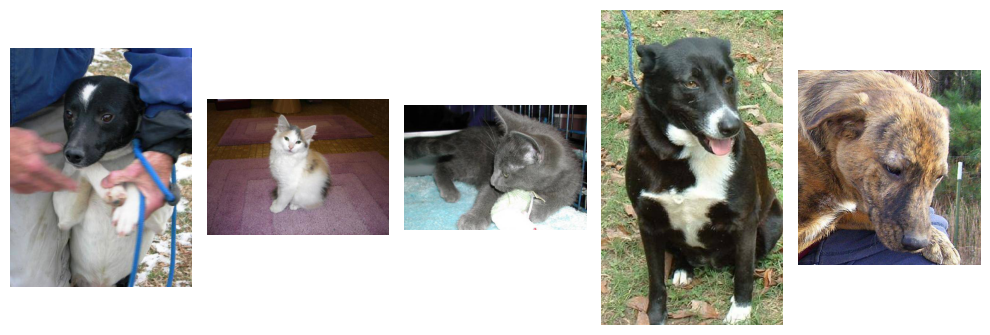

In [10]:
visualize(test_images_path)

### Distribution of data

In [11]:
train_images_path[0]

'train_data/train/cat.0.jpg'

In [12]:
train_images_path[0].split('/')[-1].split('.')[0]

'cat'

In [13]:
def count_cats_dogs(image_files_path):
    cats = 0
    dogs = 0
    for img_path in image_files_path:
        if img_path.split('/')[-1].split('.')[0] == 'cat':
            cats +=1
        else:
            dogs +=1
    return dogs, cats

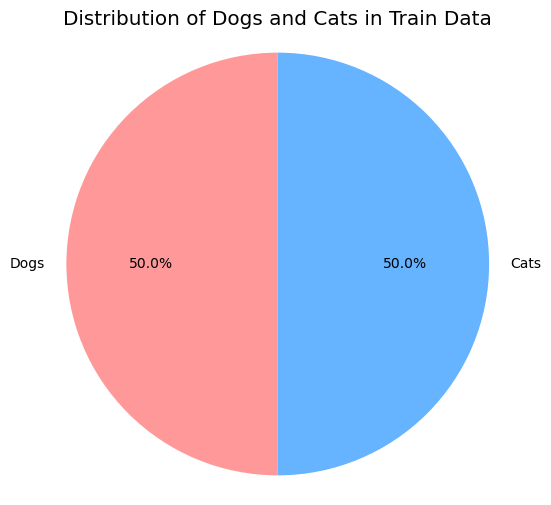

In [14]:
# Create a pie chart of train data
plt.figure(figsize=(6, 6))
labels = ['Dogs', 'Cats']
dogs, cats = count_cats_dogs(train_images_path)
sizes = [dogs, cats]

# display
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Distribution of Dogs and Cats in Train Data")
plt.show()

Balance train data

In [15]:
# Check image size and distribution
def explore_image_size(img_files_path):
    sizes = []
    for img_path in img_files_path:
        img = Image.open(img_path)
        sizes.append(img.size)

    # Plot image size distribution
    sizes = np.array(sizes)
    plt.figure(figsize=(6, 4))
    plt.scatter(sizes[:, 0], sizes[:, 1], alpha=0.5)
    plt.title('Image Size Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.show()

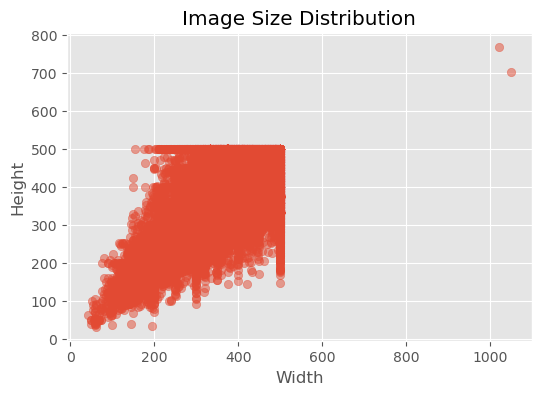

In [16]:
# Check size distribution of train data
explore_image_size(train_images_path)

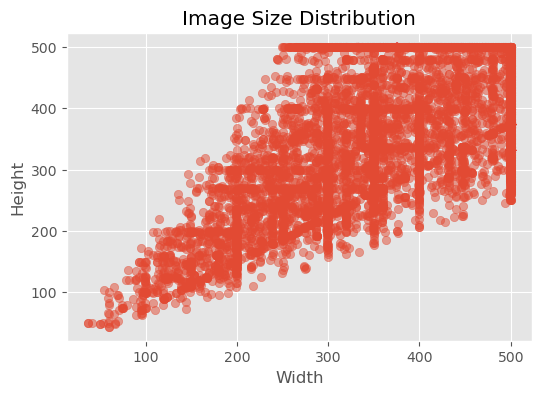

In [17]:
# Check size distribution of test data
explore_image_size(test_images_path)

## Data Preprocessing

### Get images into Dataframe

In [18]:
# Lưu các thông tin ảnh vào DataFrame
def create_dataframe(image_paths):
    image_name = []
    category = []
    code = []
    size = []
    aspect_ratio = []

    for image_path in image_paths:
        image_name.append(os.path.basename(image_path))
        cate=os.path.basename(image_path).split('.')[0]
        category.append(cate)
        code.append(1) if cate=='dog'  else code.append(0)

        # Read the image to get its size (height, width)
        img=cv2.imread(image_path)
        size.append((img.shape[0],img.shape[1]))
        # Calculate and append the aspect ratio (height/width) of the image
        aspect_ratio.append(img.shape[0]/img.shape[1])

    train_df = pd.DataFrame({'Image_Name':image_name,
                             'Category':category,
                             'Code':code,"Size":size,
                             'Aspect_ratio':aspect_ratio
                             })

    return train_df

In [19]:
train_df = create_dataframe(train_images_path)

In [20]:
train_df

Image_Name Category  Code        Size  Aspect_ratio
0         cat.0.jpg      cat     0  (374, 500)      0.748000
1         cat.1.jpg      cat     0  (280, 300)      0.933333
2        cat.10.jpg      cat     0  (499, 489)      1.020450
3       cat.100.jpg      cat     0  (499, 403)      1.238213
4      cat.1000.jpg      cat     0  (149, 150)      0.993333
...             ...      ...   ...         ...           ...
24995  dog.9995.jpg      dog     1  (224, 300)      0.746667
24996  dog.9996.jpg      dog     1  (262, 349)      0.750716
24997  dog.9997.jpg      dog     1  (374, 500)      0.748000
24998  dog.9998.jpg      dog     1  (499, 331)      1.507553
24999  dog.9999.jpg      dog     1   (150, 96)      1.562500

[25000 rows x 5 columns]

In [21]:
# Define a function to display the first 9 images from a DataFrame 
def display_first_9(path,df):
    plt.figure(figsize=(20,20))
    for i in range(9):
        plt.subplot(3,3,i+1)
        img_path=os.path.join(path,df['Image_Name'].iloc[i])
        plt.title(df['Image_Name'][i])
        img=Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

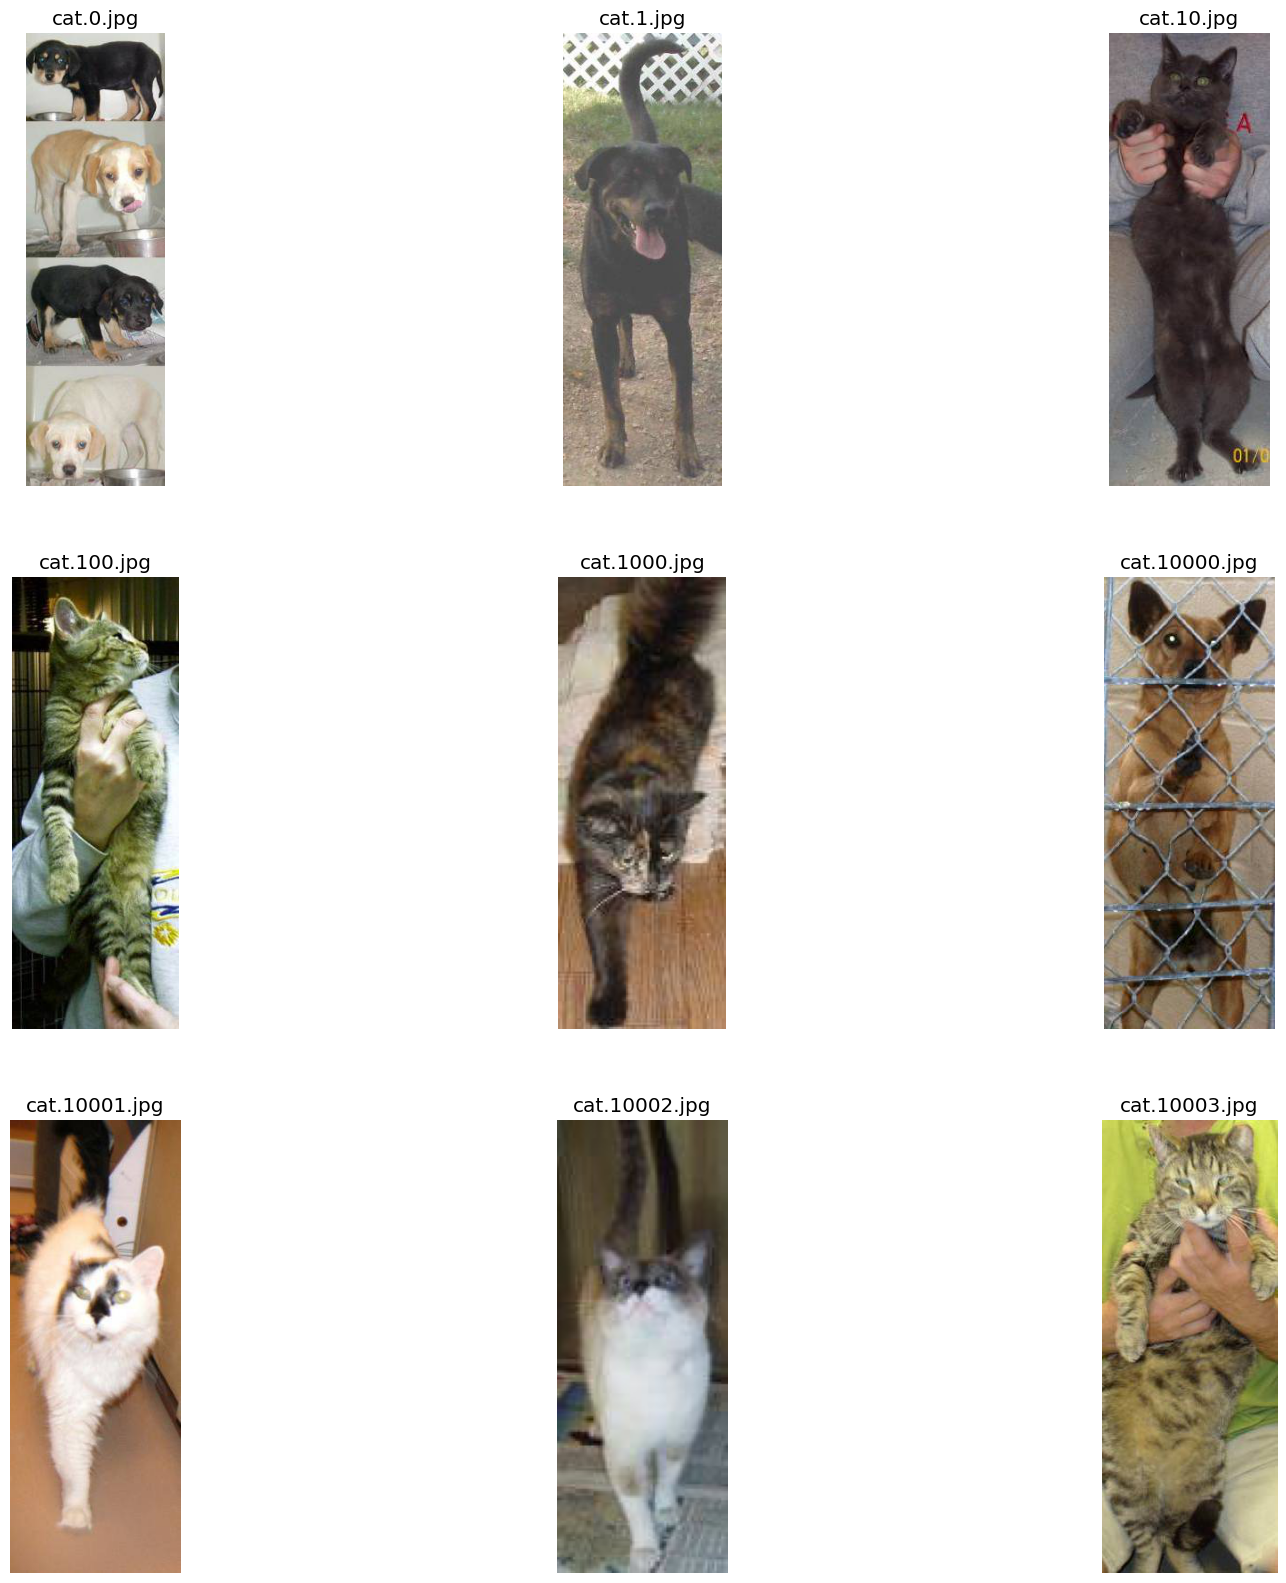

In [22]:
# Sắp xếp theo tỷ lệ khung hình và hiển thị các ảnh có tỷ lệ khung hình cực đoan (lớn nhất)
df_sorted=train_df.sort_values(by='Aspect_ratio',ascending=False)
display_first_9(train_folder,df_sorted)

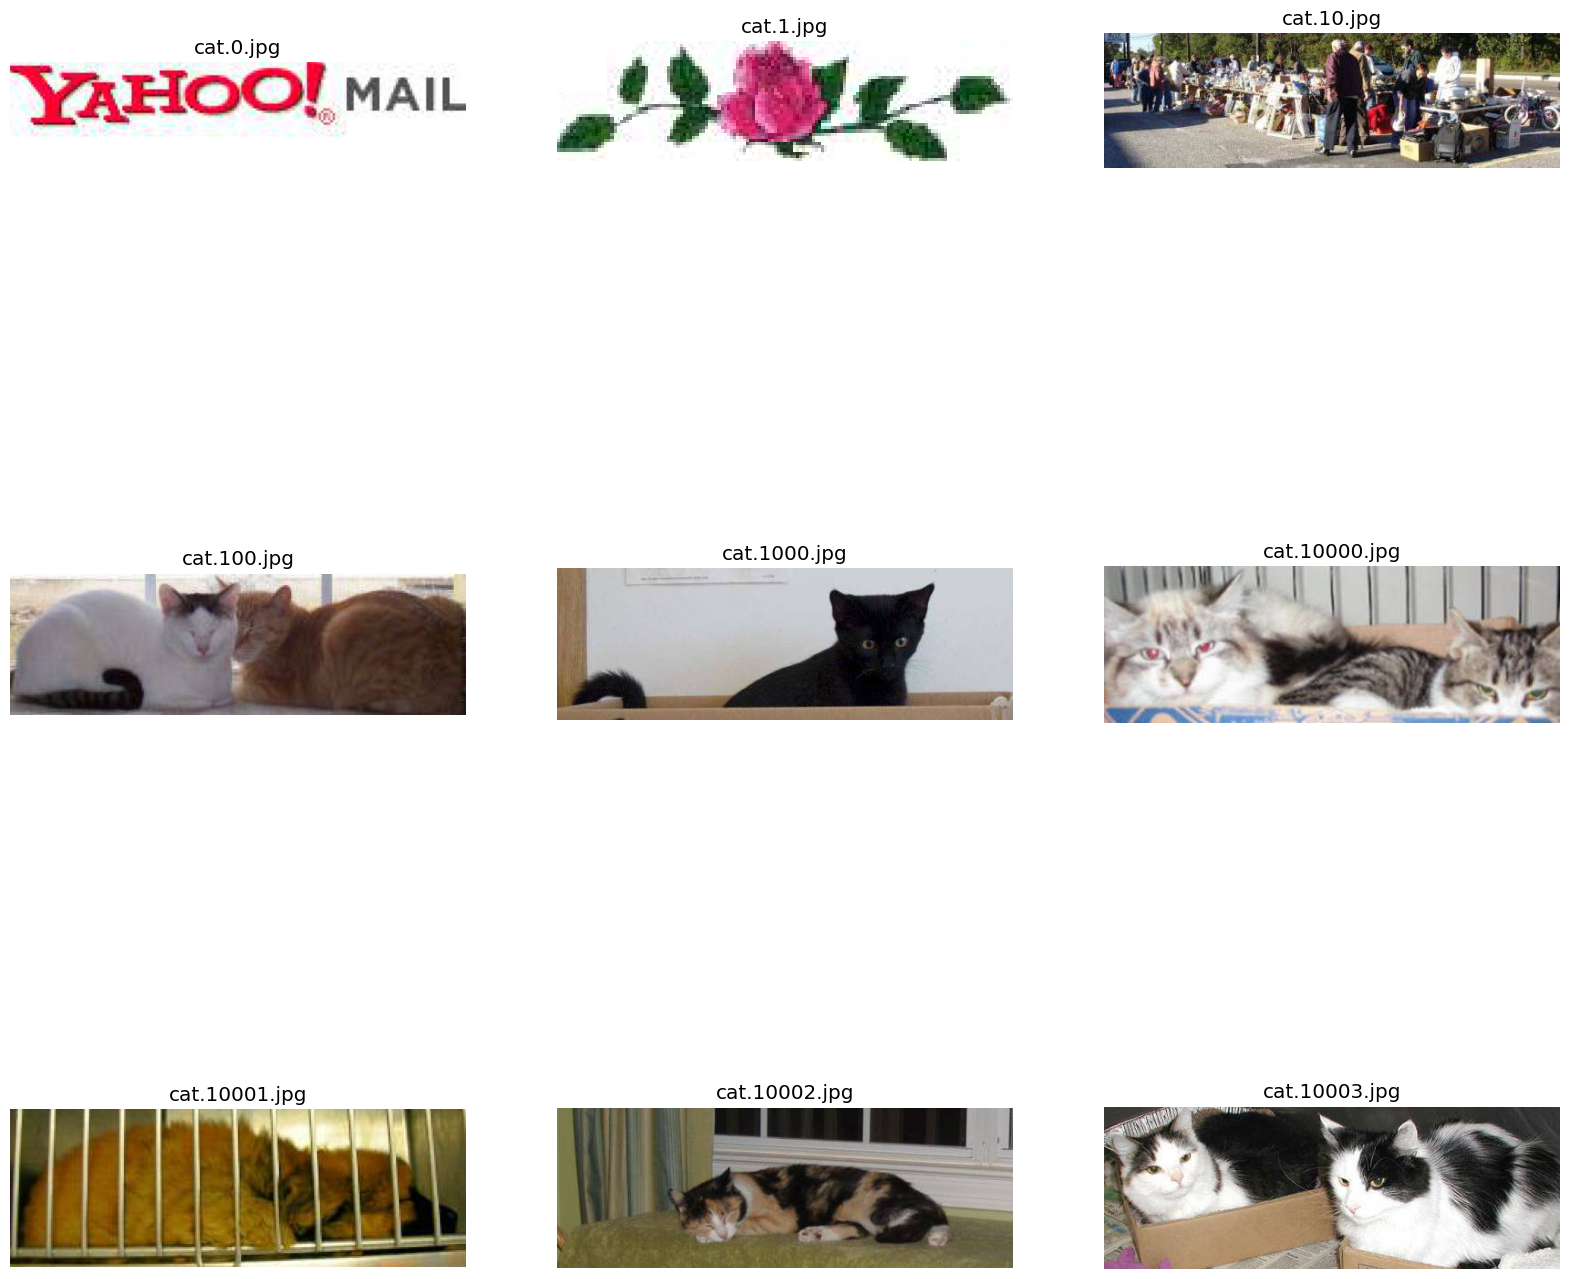

In [23]:
# Sắp xếp theo tỷ lệ khung hình và hiển thị các ảnh có tỷ lệ khung hình cực đoan (bé nhất)
df_sorted=train_df.sort_values(by='Aspect_ratio',ascending=True)
display_first_9(train_folder,df_sorted)

now we can find that there are 3 image that dosen't belong to out data and they might have come from scraping some websites

In [24]:
# Lấy tên của 3 ảnh cần xóa từ DataFrame đã sắp xếp
images_to_remove = df_sorted['Image_Name'].iloc[:3].tolist()

# In ra các path cần xóa để kiểm tra
print("Paths to be removed:", images_to_remove)

Paths to be removed: ['dog.4367.jpg', 'cat.9171.jpg', 'cat.5351.jpg']


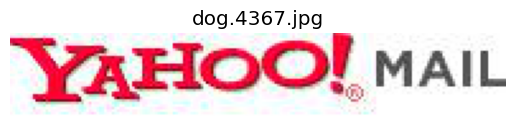

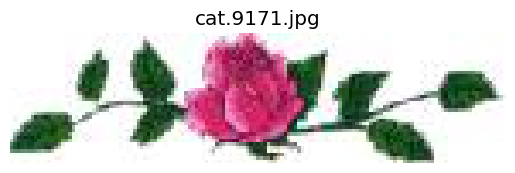

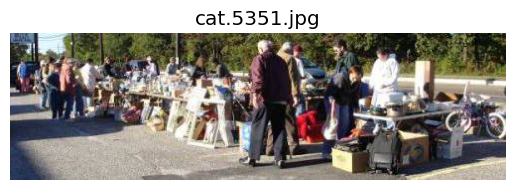

In [25]:
# Kiểm tra xem có đúng là các ảnh cần xoá không
for i in images_to_remove:
    img_path = f"train_data/train/{i}"  # Sử dụng f-string để định dạng đúng
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(i)  # Hiển thị tên ảnh trên mỗi ảnh
    plt.axis('off')
    plt.show()  # Hiển thị từng ảnh một


In [26]:
# Xóa các path tương ứng trong train_images_path
train_images_path = [path for path in train_images_path if os.path.basename(path) not in images_to_remove]

# Kiểm tra lại xem các path đã bị xóa chưa
for image in images_to_remove:
    image_path = f'train_data/train/{image}'
    if image_path not in train_images_path:
        print(f"Path {image_path} was successfully removed.")
    else:
        print(f"Path {image_path} is still in the list.")

Path train_data/train/dog.4367.jpg was successfully removed.
Path train_data/train/cat.9171.jpg was successfully removed.
Path train_data/train/cat.5351.jpg was successfully removed.


In [27]:
# Create a pipeline to preprocessing data
IMAGE_SIZE = (224, 224)
def load_data(image_files_path):
    images = []
    labels = []

    print("Loading images...")
    for img_path in tqdm(image_files_path):
        # Open and resize the image
        image = cv2.imread(img_path) # Đọc hình ảnh từ đường dẫn
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Chuyển đổi màu sắc từ BGR (định dạng mặc định của OpenCV) sang RGB.
        image = cv2.resize(image, IMAGE_SIZE) # Thay đổi kích thước hình ảnh về kích thước mong muốn.
        images.append(image)

        # Extract label from the image path (assuming the filename indicates the class)
        image_class = os.path.basename(img_path).split('.')[0]
        labels.append(1 if image_class == 'dog' else 0)

    # Convert to NumPy arrays
    images_array = np.array(images, dtype='float32')
    labels_array = np.array(labels, dtype='int32')

    return images_array, labels_array


In [28]:
train_images, train_labels = load_data(train_images_path)

Loading images...


100%|██████████| 24997/24997 [00:25<00:00, 969.49it/s] 


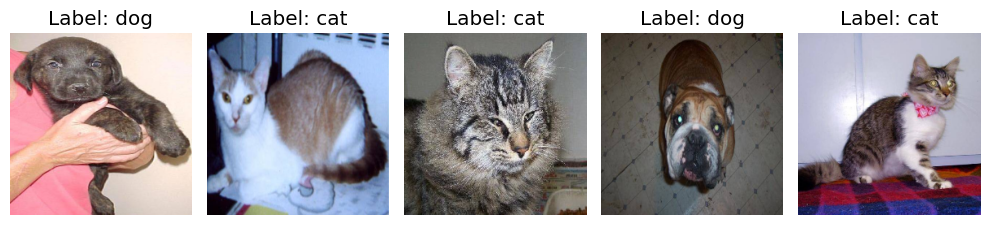

In [29]:
# Show the image in train data (normalise to between 0 and 1)
my_map = {
    0: 'cat',
    1: 'dog'
}
def show_random(samples=5):
    plt.figure(figsize=(10,10))
    for i in range(samples):
        r = random.randint(0, len(train_images))
        plt.subplot(1, samples, i+1)
        plt.imshow(train_images[r]/255.0)
        plt.title(f"Label: {my_map[train_labels[r]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_random()

### Split the training data into train, test, and validation sets


In [30]:
# First split: 80% training 20% validation
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, shuffle=True, random_state=42)

print("Kích thước của tập train:", len(X_train))
print("Kích thước của tập validation:", len(X_val))

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Kích thước của tập train: 19997
Kích thước của tập validation: 5000
Training data shape: (19997, 224, 224, 3)
Validation data shape: (5000, 224, 224, 3)


## CNN Creation

In [45]:
input_shape = (224, 224, 3)
epochs = 15
batch_size = 32
n_splits = 5

model  = Sequential()

# Input layer
model.add(Input(shape=input_shape))

# Hidden layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# Fully Connected layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
    
# Output layer
model.add(Dense(1, activation='sigmoid')) 


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,263,809 (73.49 MB)

 Trainable params: 19,263,809 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

### Callbacks

In [46]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr=0.00001,
                                            verbose=1)

* Mục đích: ReduceLROnPlateau là một callback trong Keras, dùng để giảm learning rate khi giá trị được giám sát (ở đây là val_accuracy, tức độ chính xác trên tập xác thực) không cải thiện sau một số epoch nhất định.

* Cấu trúc các tham số:

    - monitor='val_accuracy': Giám sát độ chính xác trên tập xác thực (val_accuracy). Nếu sau vài epoch độ chính xác không cải thiện, learning rate sẽ được giảm.
    - patience=2: Sau 2 epoch không có cải thiện về val_accuracy, learning rate sẽ được giảm.
    - factor=0.5: Khi giảm, learning rate sẽ được nhân với 0.5 (tức là giảm đi một nửa).
    - min_lr=0.00001: Giới hạn dưới của learning rate. Khi giảm, learning rate sẽ không giảm xuống dưới giá trị này.
    - verbose=1: In ra thông tin khi giảm learning rate.
* Lợi ích: Khi quá trình học bị chậm lại (có nghĩa là mô hình không cải thiện dù có nhiều epoch huấn luyện), callback này giúp mô hình học chậm hơn bằng cách giảm tốc độ học (learning rate), cho phép tìm kiếm các giá trị tối ưu hơn.

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

* Mục đích: EarlyStopping dừng quá trình huấn luyện sớm nếu mô hình không còn cải thiện sau một số epoch nhất định.

* Cấu trúc các tham số:

    - monitor='val_loss': Theo dõi giá trị hàm mất mát trên tập xác thực (val_loss). Nếu sau vài epoch giá trị này không cải thiện, quá trình huấn luyện sẽ dừng lại.
    - patience=2: Chờ 2 epoch không có cải thiện trước khi dừng huấn luyện.
    - restore_best_weights=True: Sau khi dừng sớm, callback này sẽ khôi phục lại trọng số tốt nhất của mô hình (tức là trọng số tại epoch có val_loss nhỏ nhất).
    - verbose=0: Không in ra thông báo khi dừng sớm.
* Lợi ích: Giúp tiết kiệm thời gian khi mô hình không còn cải thiện nữa. Đồng thời tránh hiện tượng overfitting khi mô hình bắt đầu học quá mức và không  tổng quát tốt trên dữ liệu mới.

### Data Augmentation

In [55]:
## Tăng cường dữ liệu cho bộ dữ liệu huấn luyện
def create_data_generators(X_train, y_train, X_val, y_val, img_size=(224, 224), batch_size=32):
    # Tăng cường dữ liệu cho tập huấn luyện
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Chuẩn hóa giá trị điểm ảnh
        # rotation_range=40,  # Xoay mạnh hơn
        # width_shift_range=0.3,  # Dịch chuyển ngang
        # height_shift_range=0.3,  # Dịch chuyển dọc
        # shear_range=0.3,  # Nghiêng hình
        zoom_range=[0.8, 1.2],  # Phóng to/thu nhỏ
        horizontal_flip=True,  # Lật ngang hình ảnh
        vertical_flip=True,  # Lật dọc hình ảnh
        fill_mode='nearest',  # Điền vào các pixel bị thiếu
        brightness_range=[0.8, 1.2],  # Điều chỉnh độ sáng
        channel_shift_range=50.0  # Dịch chuyển màu ngẫu nhiên
    )

    # Bộ sinh dữ liệu xác nhận và kiểm tra, chỉ chuẩn hóa (rescale)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Tạo các bộ sinh dữ liệu từ mảng NumPy
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=batch_size,
    )

    val_generator = val_datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
    )

    return train_generator, val_generator


In [48]:
# Tạo các generator
train_generator, val_generator = create_data_generators(X_train, y_train, X_val, y_val)

# Kiểm tra kích thước của tập dữ liệu
print(f"Kích thước của tập train: {len(train_generator)}")
print(f"Kích thước của tập validation: {len(val_generator)}")

Kích thước của tập train: 625
Kích thước của tập validation: 157


Số lượng batches = Tổng số ảnh / batch_size
Với batch_size = 32

### Show Sample From Train Data after augmentation

In [49]:
sample_batch=next(train_generator)
images,labels=sample_batch

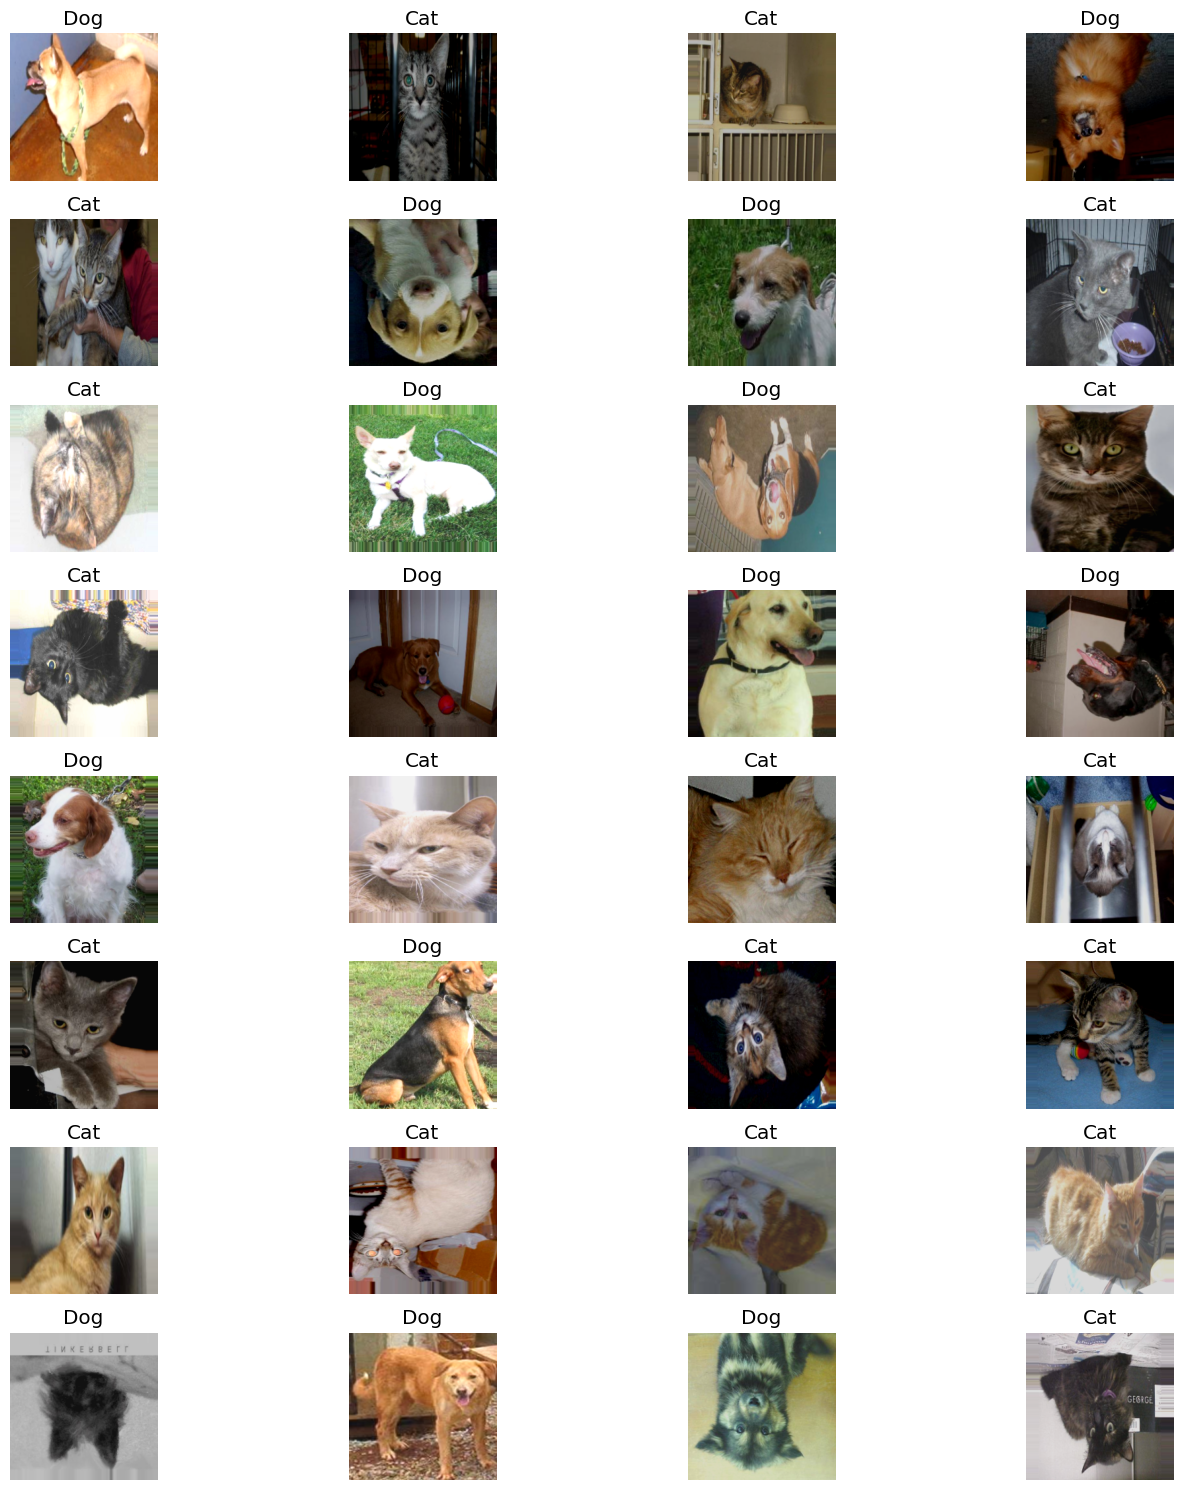

In [50]:
# this is what the resnet expect 
plt.figure(figsize=(15,15))
for i in range(batch_size):
    plt.subplot(8,4,i+1)
    plt.imshow(images[i])
    label_index = labels[i]
    label='Cat' if label_index ==0 else 'Dog'
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Fit Model

In [51]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = epochs,
    callbacks = [learning_rate_reduction, early_stopping],
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 732s 1s/step - accuracy: 0.5819 - loss: 0.6648 - val_accuracy: 0.6762 - val_loss: 0.6006 - learning_rate: 1.0000e-04
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1016s 2s/step - accuracy: 0.7033 - loss: 0.5682 - val_accuracy: 0.7052 - val_loss: 0.5714 - learning_rate: 1.0000e-04
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 858s 1s/step - accuracy: 0.7309 - loss: 0.5326 - val_accuracy: 0.7724 - val_loss: 0.4927 - learning_rate: 1.0000e-04
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 760s 1s/step - accuracy: 0.7521 - loss: 0.5082 - val_accuracy: 0.7744 - val_loss: 0.4723 - learning_rate: 1.0000e-04
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.7715 - loss: 0.4737 - val_accuracy: 0.7636 - val_loss: 0.4943 - learning_rate: 1.0000e-04
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 863s 1s/step - accuracy: 0.7908 - loss: 0.4489 - val_accuracy: 0.7920 - val_loss: 0.4568 - learning_rate: 1.0000e-04
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 813s 1s/step - ac

In [53]:
def plot_loss(history) :
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")


def plot_acc(history) :
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

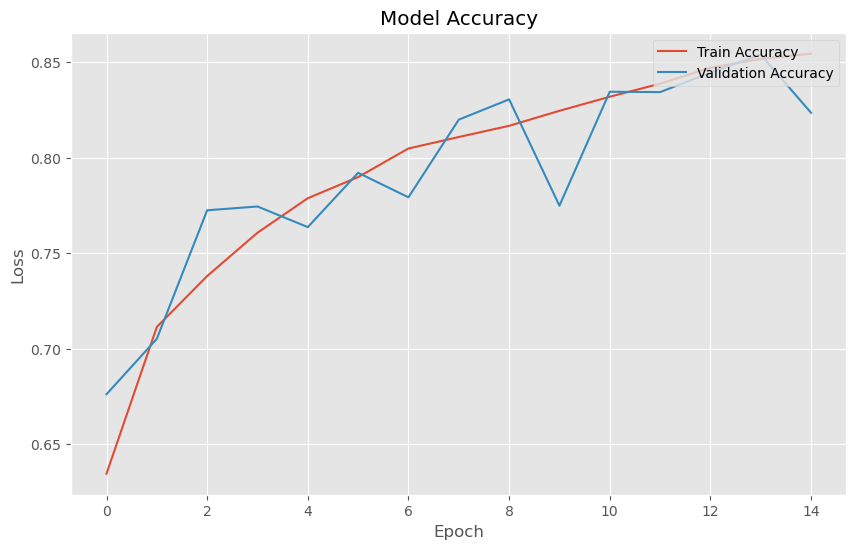

Validation Loss: 45.0079
Validation Accuracy: 0.7370


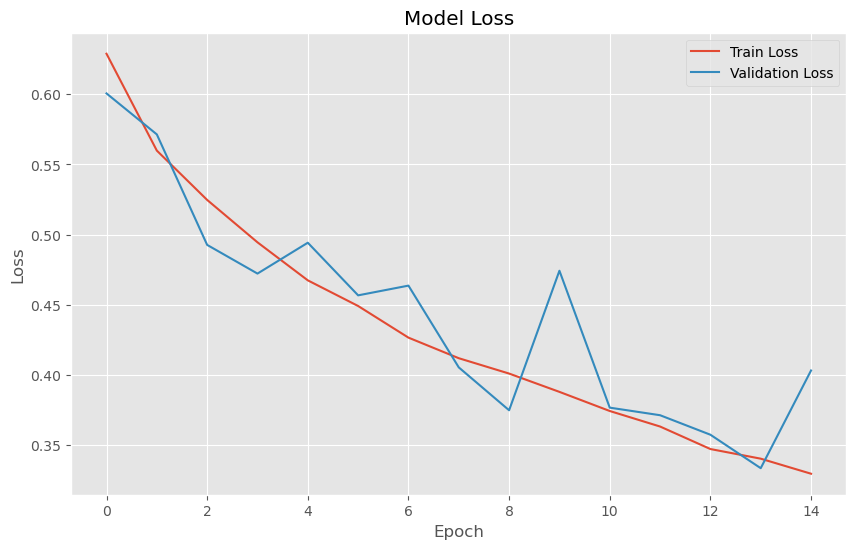

Validation Loss: 45.0079
Validation Accuracy: 0.7370


In [54]:
plot_acc(history)
plot_loss(history)

## Make Prediction

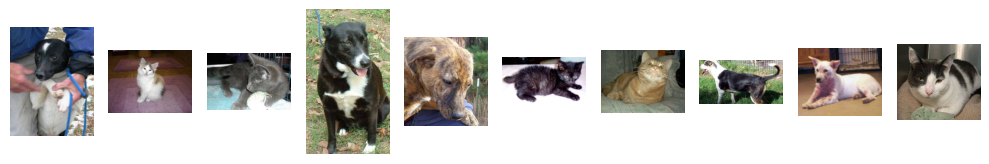

In [56]:
visualize(test_images_path, 10)

In [58]:
test_images_path[1509]

'test_data/test1/11356.jpg'

In [68]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Đọc hình ảnh từ đường dẫn
    image = cv2.imread(image_path)
    
    # Chuyển đổi màu sắc từ BGR sang RGB (OpenCV mặc định là BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Thay đổi kích thước ảnh về đúng với kích thước đầu vào của mô hình (224x224)
    image = cv2.resize(image, target_size)
    
    # Chuẩn hóa giá trị ảnh (từ 0-255 về 0-1)
    image = image.astype('float32') / 255.0
    
    # Thêm một chiều batch (mô hình cần đầu vào là dạng (1, 224, 224, 3))
    image = np.expand_dims(image, axis=0)
    
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


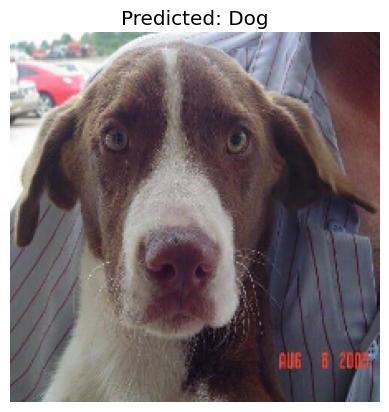

In [74]:
# Chọn một ảnh ngẫu nhiên từ test_images_path
random_idx = random.randint(0, len(test_images_path) - 1)
selected_image_path = test_images_path[random_idx]

# Tiền xử lý ảnh được chọn
img_array = preprocess_image(selected_image_path)

# Dự đoán nhãn cho ảnh đó
predictions = model.predict(img_array)

# Chuyển từ xác suất sang nhãn dự đoán (giả sử bạn có mô hình phân loại nhị phân)
predicted_class = (predictions > 0.5).astype("int32")

# Bản đồ nhãn của bạn (giả sử là Cat và Dog)
mymap = {0: "Cat", 1: "Dog"}

# Hiển thị ảnh và nhãn dự đoán
plt.imshow(np.squeeze(img_array, axis=0))  # Loại bỏ chiều batch và hiển thị ảnh
plt.title(f"Predicted: {mymap[predicted_class[0][0]]}")  # Tiêu đề là nhãn dự đoán
plt.axis('off')  # Tắt khung trục
plt.show()